## Table of Contents:
* [Preliminaries](#Preliminaries)
* [Start: normal and historical simulation](#Start: normal and historical simulation)
* [Non-normality](#Non-normality)
* [T-distribution](#T-distribution)
* [Calculation results](#Calculation results)
* [Analysis of the impact of confidence level on risk measures](#Analysis of the impacts of confidence level on risk measures)
* [Impact of time horizon (normality assumption)](#Impact of time horizon (normality assumption))
    

We often hear that some assets or markets are “riskier” than others. While this makes sense from the intuitive point of view, the question is, whether we could show this numerically, on the real data using real numbers? This project will answer this question by taking several stock indices from several markets, both developed and developing, and computing the risk measures associated with these indices using parametric and non-parametric approaches. By using different approaches to computation, we would be able to implicitly answer another question: what approach to calculation is better from the risk management standpoint? While we know that non-parametric approach is free from limiting assumptions about the distribution of our data which would probably lead to more accurate risk picture, it is more computationally burdensome than the parametric approaches which could be an issue for large datasets. So, maybe parametric approaches would be able to capture the risk while staying more computationally efficient?

Moreover, in this project the overall riskiness will be evaluated not only by a single number from risk measure, but also by analyzing the impact of key parameters on that risk measure. These key parameters include the confidence level and the time horizon over which the risk measure is computed. By doing this, we hope to get a more or less clear picture of what markets are riskier and what are less.


# Preliminaries

We start with loading all necessary libraries

In [69]:
library(quantmod)
library(fitdistrplus)
library(readxl)
library(QRM)
library(evir)
library(tseries)

In [156]:
library(repr)

Next, we get the data: 2 US ETF's (SPY, QQQ), Russian index (RTS), European ETF (VGK), Japanese index (Nikkei 225) and Chinese index (SSE)

In [46]:
us<-getSymbols(c('SPY','QQQ'),from='2005-03-01',to='2021-07-01')
rus<-data.frame(read_xlsx('RTS.xlsx'))
ch<-data.frame(read.csv('ch.csv'))
eur<-data.frame(read.csv('VGK.csv'))
jpn<-data.frame(read_xlsx('/Users/user/Desktop/jpn.xlsx'))

Parsing the RTS data

In [47]:
rus$Price<-gsub('\\.(?=[^.]*\\.)','',rus$Price,perl = TRUE)

Obtaining the log returns

In [48]:
ret<-function(col) {
  if (!is.numeric(col)) {col<-as.numeric(col)}
  logret<-Delt(col,type = 'log')
  logret<-na.omit(logret)
}

sp<-ret(SPY$SPY.Close)
qq<-ret(QQQ$QQQ.Close)
rts<-na.omit(ret(rus$Price))
nikk<-na.omit(ret(jpn$Close))
chin<-na.omit(ch$Returns)
eurp<-ret(eur$Close)



Plotting the prices we immediately see the impact of fianacial crisis of 2007-2009 and COVID crisis of 2020. Especially they are pronounced for RTS, VGK and SSE

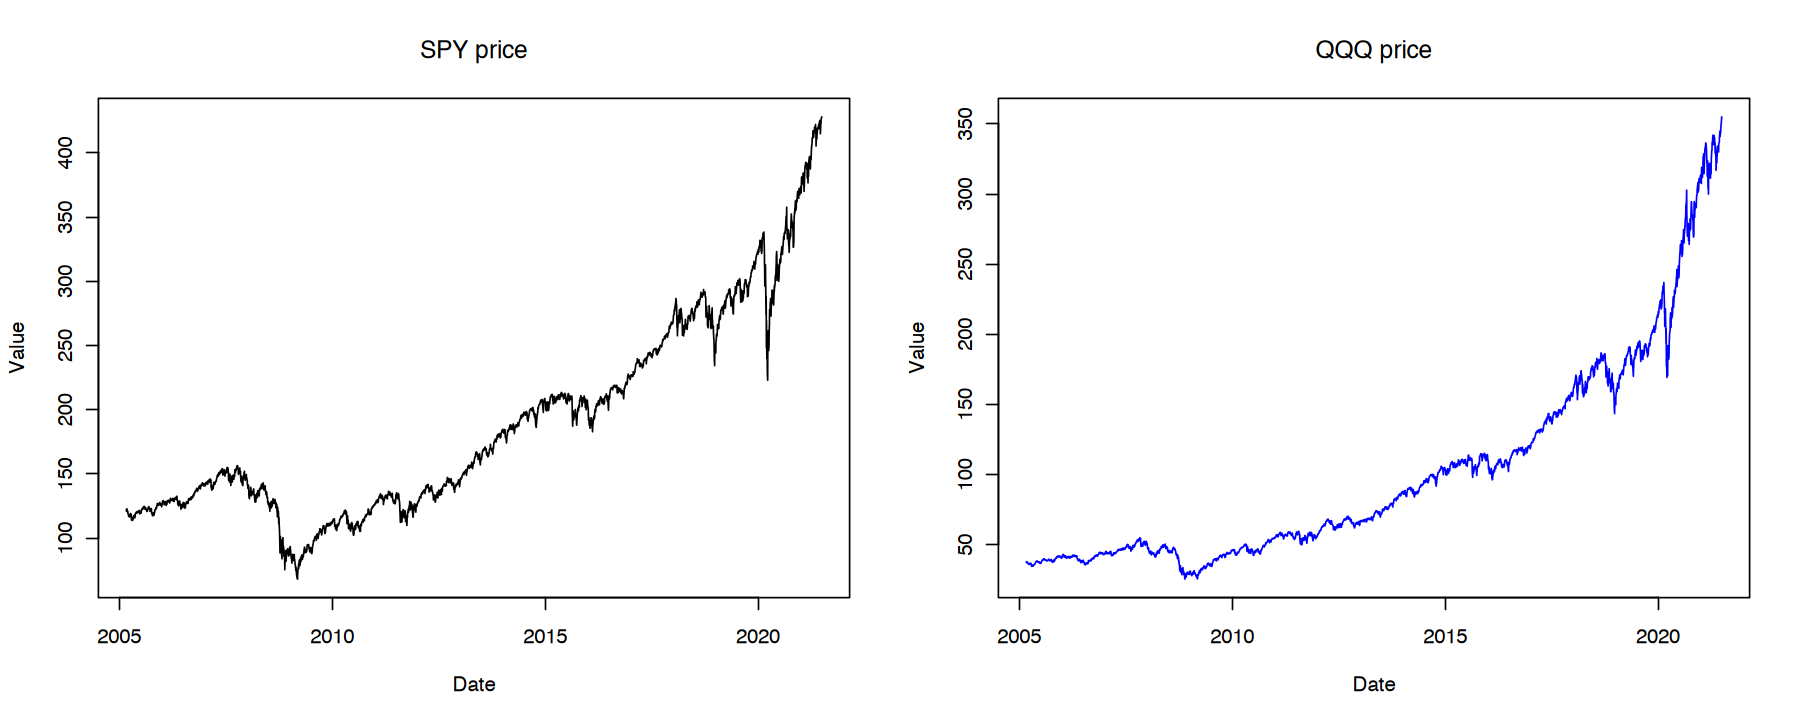

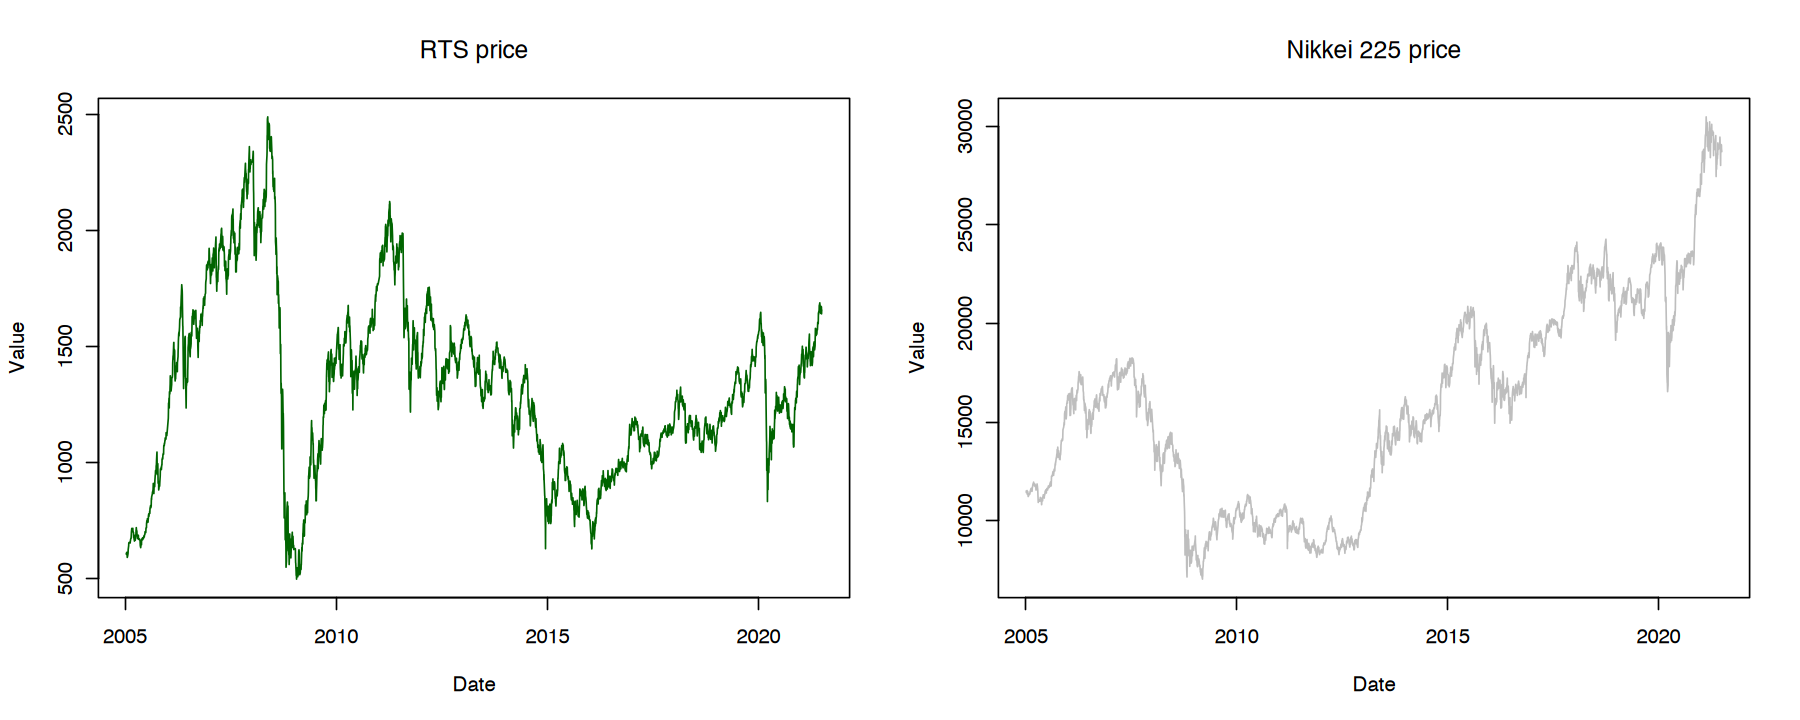

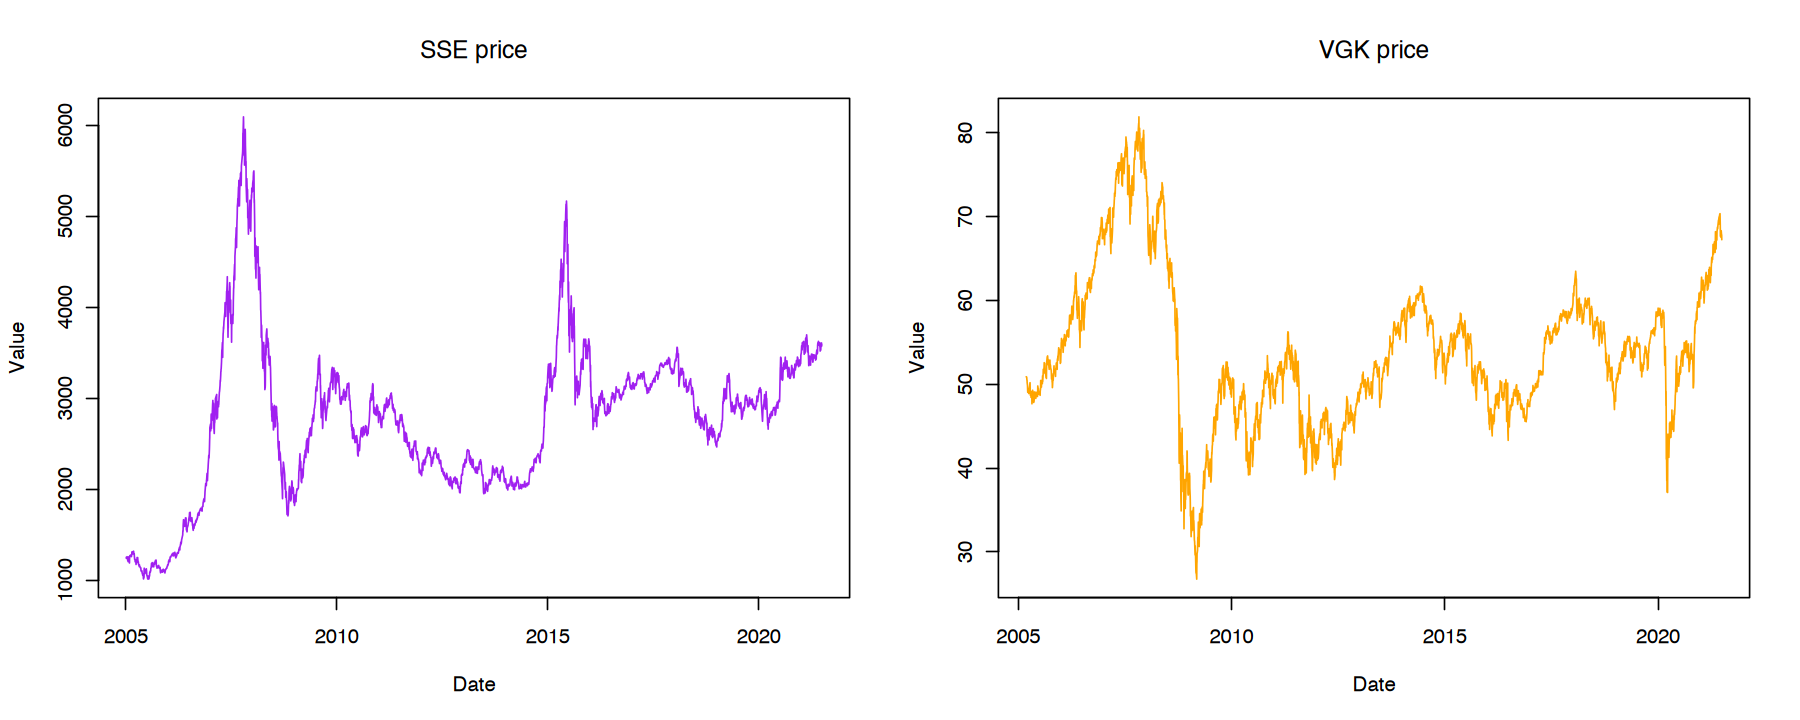

In [155]:
options(repr.plot.width=15,repr.plot.height=6)
par(mfrow=c(1,2))
plot(index(SPY),SPY$SPY.Close,type='l',xlab='Date',ylab='Value',col='black',main='SPY price')
plot(index(QQQ),QQQ$QQQ.Close,type='l',xlab='Date',ylab='Value',col='blue',main='QQQ price')
plot(rus$Date,rus$Price,type='l',xlab='Date',ylab='Value',col='dark green',main='RTS price')
plot(as.Date(jpn$Date),as.numeric(jpn$Close),type='l',xlab='Date',ylab='Value',col='grey',main='Nikkei 225 price')
plot(as.Date(ch$Date),as.numeric(ch$Close),type='l',xlab='Date',ylab='Value',col='purple',main='SSE price')
plot(as.Date(eur$Date),as.numeric(eur$Close),type='l',xlab='Date',ylab='Value',col='orange',main='VGK price')


Next we plot the empirical densities for all time series

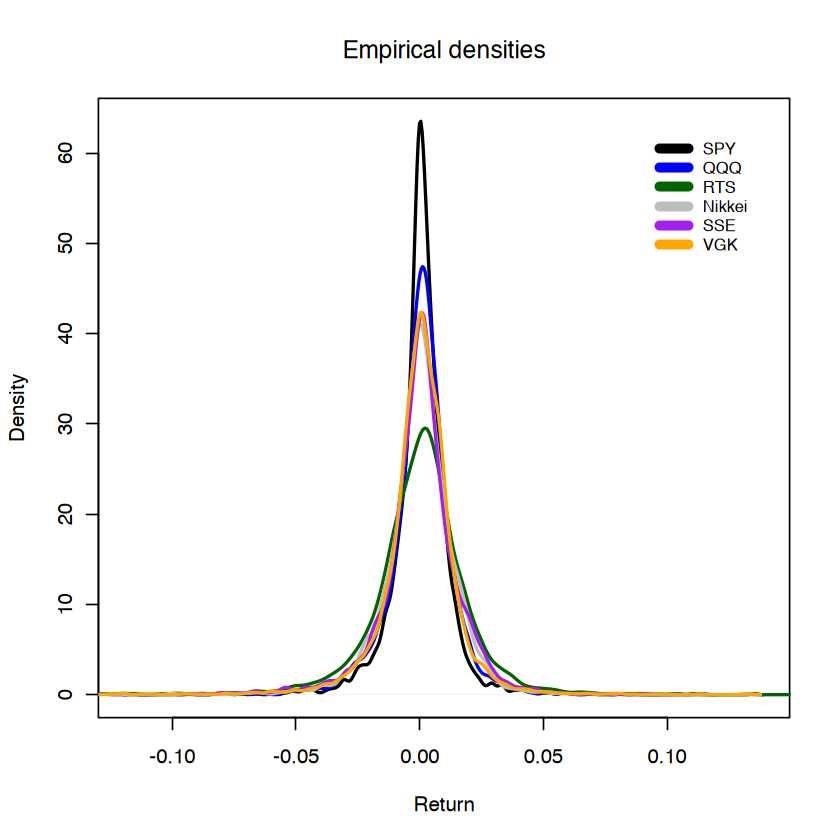

In [49]:
plot(density(sp),col='black',lwd=2,main='Empirical densities',xlab='Return')
lines(density(qq),col='blue',lwd=2)
lines(density(rts),col='dark green',lwd=2)
lines(density(nikk),col='grey',lwd=2)
lines(density(chin),col='purple',lwd=2)
lines(density(eurp),col='orange',lwd=2)
legend('topright',inset=0.05, bty="n",leg=c('SPY','QQQ','RTS','Nikkei','SSE','VGK'),
       cex=0.8, lwd=6, lty=1, col=c("black", "blue",'dark green','grey','purple','orange'))



All time series distributions have long tails which is common for financial data

# Start: normal and historical simulation

Now we start our main analysis. Firstly we group all TS into one list for convinient manipulation and function writing

In [51]:
l=list(sp,qq,eurp,rts,nikk,chin)
l2=lapply(l,function(x) as.numeric(x))

Computing summary statistics

In [57]:
summ<-lapply(l2, function(x) {
  c(summary(x)[c(1,4,6)],sd=sd(x),skewness=skewness(x),kurtosis=kurtosis(x))
  })


In [65]:
summ<-data.frame(summ)
colnames(summ)<-c('S&P500','QQQ','VGK','RTS','Nikkei 225','SSE')

In [66]:
summ

,S&P500,QQQ,VGK,RTS,Nikkei 225,SSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min.,-0.115886537,-0.1275923116,-1.253159e-01,-0.2119942425,-0.1211102046,-0.0925610000
Mean,0.000306803,0.0005454059,6.789349e-05,0.0002429308,0.0002264451,0.0002651517
Max.,0.135577301,0.1147986236,1.326995e-01,0.2020391818,0.1323459204,0.0903450000
sd,0.012345976,0.0134609049,1.539381e-02,0.0206527031,0.0147757256,0.0159016144
skewness,-0.388897613,-0.3542570764,-6.885589e-01,-0.5519787035,-0.4855252843,-0.5673333278
kurtosis,15.455248048,8.6709889416,1.062445e+01,11.9826885276,8.0278129067,4.7627427215


Next we have functions for calculation of HS and Normal VaR and ES

In [67]:
var_emp<-function(x,perc) {
  var<--quantile(x,perc)
}

es_emp<-function(x,perc) {
  var<-quantile(x,perc)
  es<--mean(x[x<var])
  return(es)
}

var_norm<-function(x,perc) {
  var<--sd(x)*qnorm(perc)
}

es_norm<-function(x,perc) {
  es<-1/(perc)*dnorm(qnorm(perc))*sd(x)
  return(es)
}


Calculating risk measures:

In [95]:
var_hs5<-lapply(l2, var_emp,perc=0.05)
var_hs1<-lapply(l2, var_emp,perc=0.01)

var_norm5<-lapply(l2, var_norm,perc=0.05)
var_norm1<-lapply(l2, var_norm,perc=0.01)

es_hs5<-lapply(l2, es_emp,perc=0.05)
es_hs1<-lapply(l2, es_emp,perc=0.01)

es_norm5<-lapply(l2, es_norm, perc=0.05)
es_norm1<-lapply(l2, es_norm, perc=0.01)


# Non-normality

Applying JB test for normality for justification of usage of non-normal distribution

In [70]:
lapply(l2,jarque.bera.test)

[[1]]

	Jarque Bera Test

data:  X[[i]]
X-squared = 41077, df = 2, p-value < 2.2e-16


[[2]]

	Jarque Bera Test

data:  X[[i]]
X-squared = 12985, df = 2, p-value < 2.2e-16


[[3]]

	Jarque Bera Test

data:  X[[i]]
X-squared = 19656, df = 2, p-value < 2.2e-16


[[4]]

	Jarque Bera Test

data:  X[[i]]
X-squared = 24942, df = 2, p-value < 2.2e-16


[[5]]

	Jarque Bera Test

data:  X[[i]]
X-squared = 11003, df = 2, p-value < 2.2e-16


[[6]]

	Jarque Bera Test

data:  X[[i]]
X-squared = 4003.5, df = 2, p-value < 2.2e-16



To determine an applicable degrees of freedom parameter for t distribution, perform MS plots for all time series. The moment of certain order is infinite if there is no clear convergence of the plot to 0. For Student's t-distribution with **p** degrees of freedom all moments starting from **p** and higher are infinite

In [71]:
MSplot<- function(data,p=5) {
  par(mfrow=c(3,2))
  x=abs(data)
  for (i in 1:p) {
    y=x^i
    S=cumsum(y)
    M=cummax(y)
    R=M/S
    plot(1:length(x),R,type='l',col='blue',lwd=3,ylim=c(0,1),xlab='n',ylab='Rn',main=paste("MSplot for p=",i))
  }
  par(mfrow=c(1,1))
}

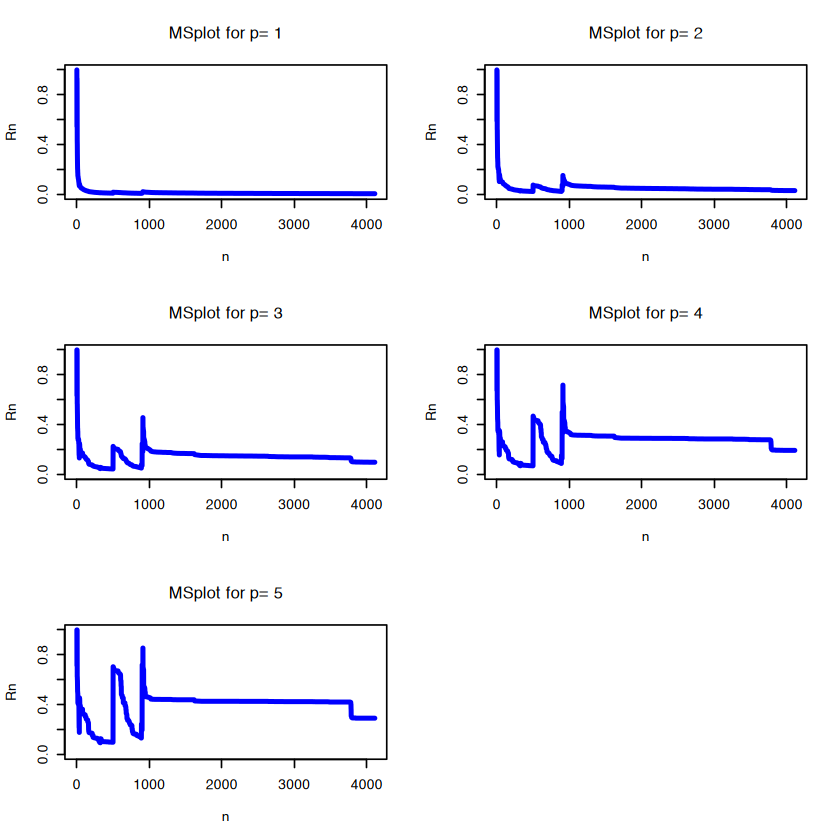

In [72]:
MSplot(sp)

4'th moment is most likely infinite

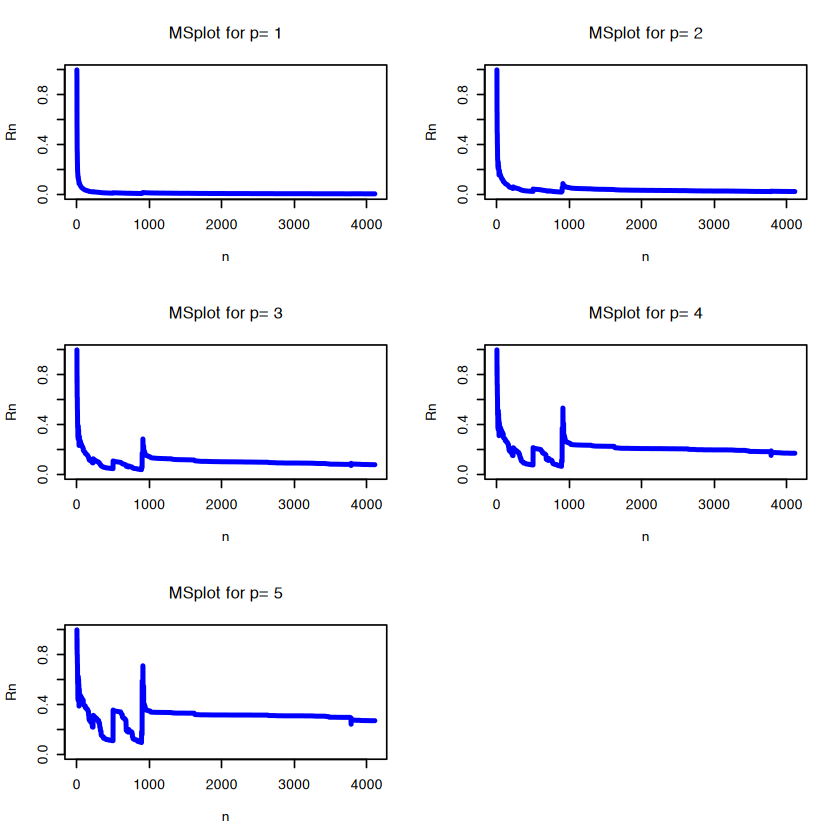

In [73]:
MSplot(qq)

4'th moment is most likely infinite

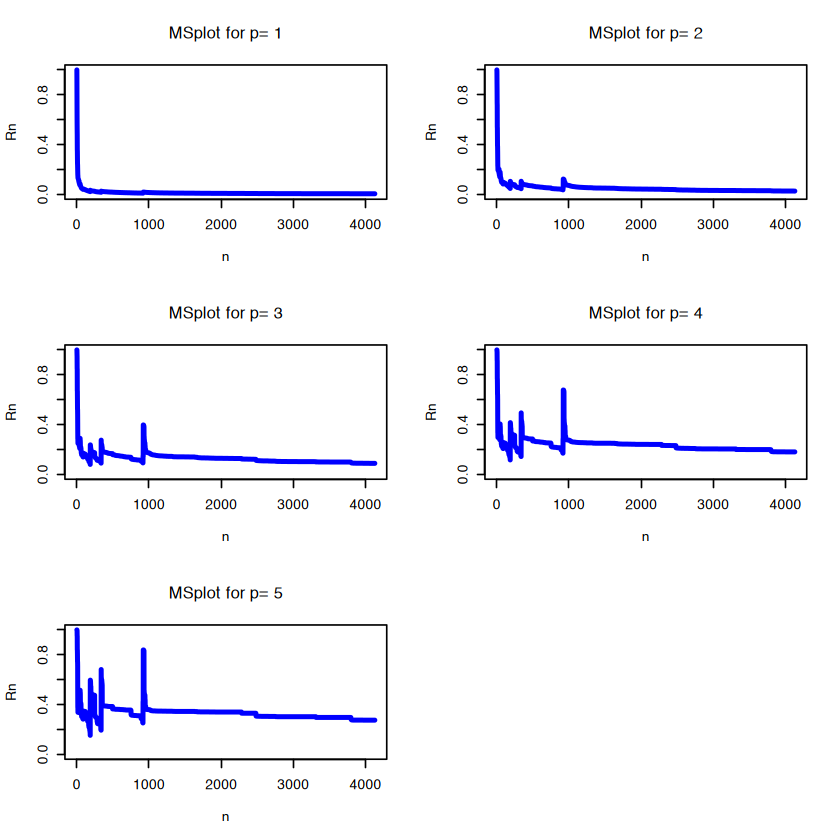

In [75]:
MSplot(rts)

4'th moment is most likely infinite

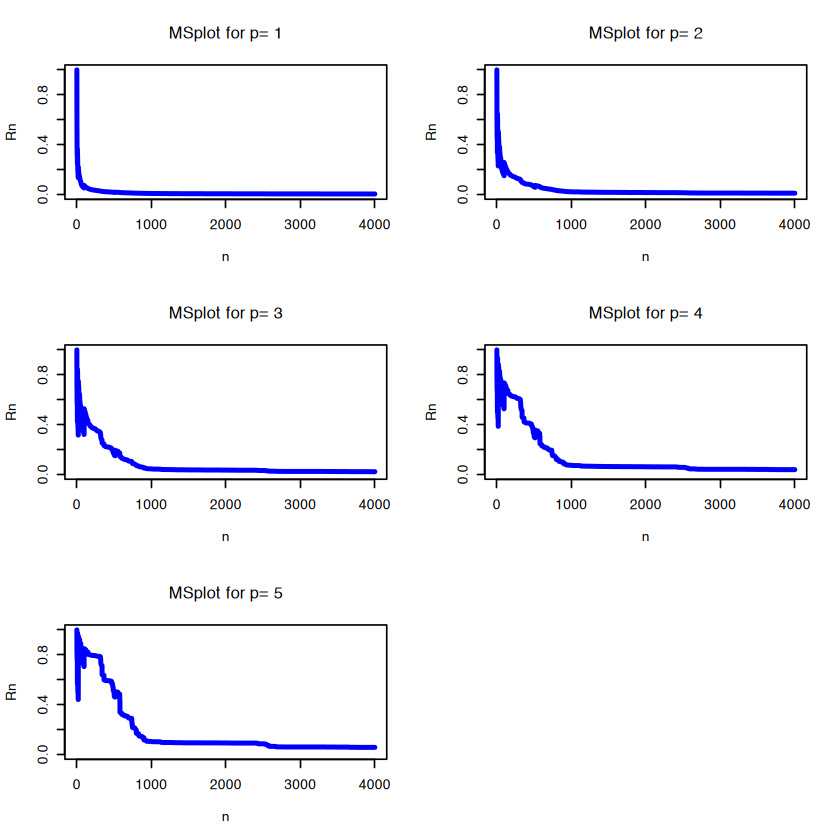

In [77]:
MSplot(chin)

All the moments for SSE seem finite (surprisingly)

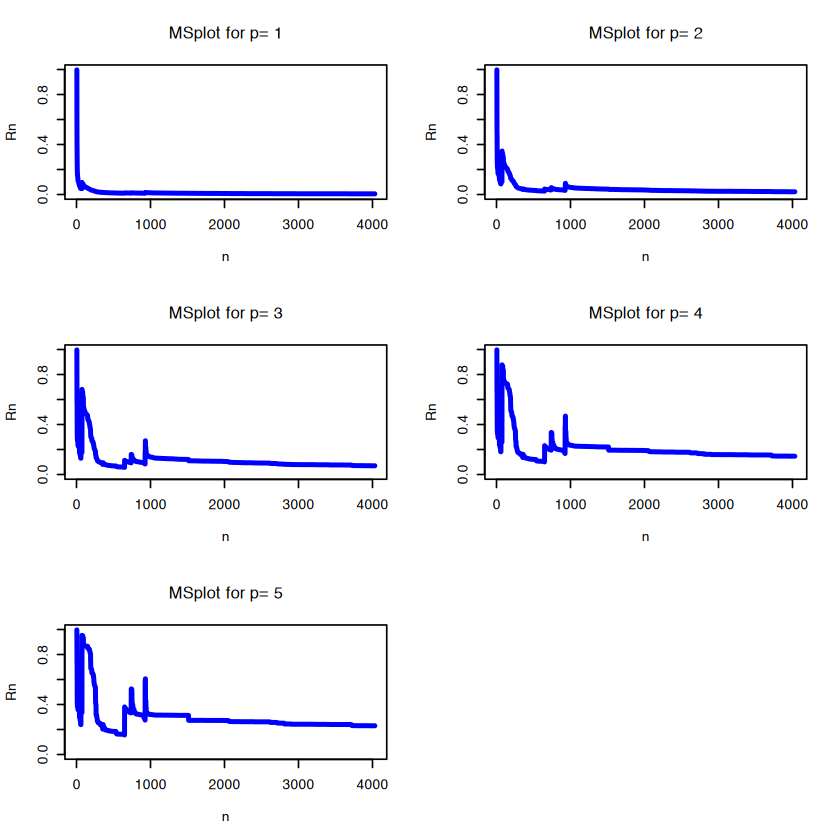

In [76]:
MSplot(nikk)

4'th moment is most likely infinite

Overall, for most indices the 4'th moment and beyond are infinite. For SPY and RTS there is doubt even for 3rd moment.


# T-distribution

Functions to calculate VaR and ES for t distribution

In [157]:
var_stud<-function(ret, df,cl) {
  var <- -sd(ret)*sqrt((df-2)/df)*qt(cl,df)
  return(var)
}

es_stud<-function(ret, df,cl) {
    es<-(sd(ret)/cl)*((df+qt(cl,df)^2)/(df-1))*dt(qt(p=cl,df=df),df)
    return(es)
}

We choose 2 possible values of degrees of freedom: **3** (more extreme) and **5** (more moderate) and calculate risk measures

In [94]:
df1=5
cl1=0.05
df2=3
cl2=0.01

var_st5_5<-lapply(l2, var_stud,df=df1,cl=cl1)
var_st1_5<-lapply(l2, var_stud,df=df1,cl=cl2)
var_st5_3<-lapply(l2, var_stud,df=df2,cl=cl1)
var_st1_3<-lapply(l2, var_stud,df=df2,cl=cl2)

es_st5_5<-lapply(l2, es_stud,df=df1,cl=cl1)
es_st1_5<-lapply(l2, es_stud,df=df1,cl=cl2)
es_st5_3<-lapply(l2, es_stud,df=df2,cl=cl1)
es_st1_3<-lapply(l2, es_stud,df=df2,cl=cl2)


# Calculation results

In [90]:
var_5<-data.frame(unlist(var_hs5),unlist(var_norm5),unlist(var_st5_5),unlist(var_st5_3))
rownames(var_5)<-c('S&P500','QQQ','VGK','RTS','Nikkei 225','SSE')
colnames(var_5)<-c('HS','Normal','Student 5 df','Student 3 df')

In [91]:
var_1<-data.frame(unlist(var_hs1),unlist(var_norm1),unlist(var_st1_5),unlist(var_st1_3))
rownames(var_1)<-c('S&P500','QQQ','VGK','RTS','Nikkei 225','SSE')
colnames(var_1)<-c('HS','Normal','Student 5 df','Student 3 df')

In [96]:
es_5<-data.frame(unlist(es_hs5),unlist(es_norm5),unlist(es_st5_5),unlist(es_st5_3))
rownames(es_5)<-c('S&P500','QQQ','VGK','RTS','Nikkei 225','SSE')
colnames(es_5)<-c('HS','Normal','Student 5 df','Student 3 df')

In [97]:
es_1<-data.frame(unlist(es_hs1),unlist(es_norm1),unlist(es_st1_5),unlist(es_st1_3))
rownames(es_1)<-c('S&P500','QQQ','VGK','RTS','Nikkei 225','SSE')
colnames(es_1)<-c('HS','Normal','Student 5 df','Student 3 df')

In [98]:
var_5

,HS,Normal,Student 5 df,Student 3 df
,<dbl>,<dbl>,<dbl>,<dbl>
S&P500,0.01823418,0.02030732,0.01927021,0.01677466
QQQ,0.02171229,0.02214122,0.02101045,0.01828953
VGK,0.02369997,0.02532057,0.02402743,0.02091580
RTS,0.03033238,0.03397067,0.03223577,0.02806114
Nikkei 225,0.02280271,0.02430391,0.02306269,0.02007600
SSE,0.02515135,0.02615583,0.02482003,0.02160576


In [99]:
var_1

,HS,Normal,Student 5 df,Student 3 df
,<dbl>,<dbl>,<dbl>,<dbl>
S&P500,0.03690693,0.02872104,0.03217934,0.03236592
QQQ,0.03933501,0.03131475,0.03508536,0.03528879
VGK,0.04989418,0.03581136,0.04012341,0.04035605
RTS,0.05925239,0.04804537,0.05383052,0.05414263
Nikkei 225,0.04255212,0.03437348,0.03851239,0.03873569
SSE,0.05364514,0.03699269,0.04144698,0.04168729


In [100]:
es_5

,HS,Normal,Student 5 df,Student 3 df
,<dbl>,<dbl>,<dbl>,<dbl>
S&P500,0.03116587,0.02546620,0.03568146,0.04783162
QQQ,0.03304150,0.02776598,0.03890375,0.05215115
VGK,0.03945238,0.03175301,0.04449010,0.05963974
RTS,0.05090312,0.04260060,0.05968898,0.08001410
Nikkei 225,0.03602890,0.03047808,0.04270375,0.05724511
SSE,0.04116938,0.03280046,0.04595772,0.06160711


In [101]:
es_1

,HS,Normal,Student 5 df,Student 3 df
,<dbl>,<dbl>,<dbl>,<dbl>
S&P500,0.05592037,0.03290467,0.05496958,0.08645989
QQQ,0.05368231,0.03587620,0.05993373,0.09426782
VGK,0.07006448,0.04102781,0.06853985,0.10780413
RTS,0.09201752,0.05504388,0.09195470,0.14463257
Nikkei 225,0.06205099,0.03938047,0.06578787,0.10347562
SSE,0.06637105,0.04238121,0.07080081,0.11136031


We see a significant difference in computed risk measures across assets for all of the methods. The RTS index possesses the highest risk, followed by SSE, VGK, Nikkei, QQQ, SPY. This is generally consistent with the perception of what markets are riskier. Moreover, the normal parametric method slightly overestimates 95% VaR compared to historical simulation and significantly underestimates all other measures, especially Expected Shortfall. On the contrary, Student’s t- distribution with 3 df tends to overestimate risk, especially in the tail. Thus, the best parametric method (which gives the closest results to historical simulation) is supposedly Student’s t-distribution with 5 df. 



# Analysis of the impacts of confidence level on risk measures

In [136]:
par(mar=c(1,1,1,1))

cl<-seq(0.1,0.01,by=-0.01)
cl<-c(cl,0.001)
var_cl<-matrix(nrow = 6,ncol = 11)
days<-seq(1,365,by=10)
var_day<-matrix(nrow = 6,ncol = length(days))
es_cl<-matrix(nrow = 6,ncol = 11)
es_day<-matrix(nrow = 6,ncol = length(days))
var_cl_hs<-matrix(nrow = 6,ncol = 11)
es_cl_hs<-matrix(nrow = 6,ncol = 11)
var_cl_st<-matrix(nrow = 6,ncol = 11)
es_cl_st<-matrix(nrow = 6,ncol = 11)

Calculation of risk measures for different confidence levels and methods (not very efficient)

In [146]:
for (i in 1:6) {
  for (j in 1:11) {
    var_cl[i,j]<-var_norm(unlist(l2[i]),cl[j])
  }
}

for (i in 1:6) {
  for (j in 1:11) {
    es_cl[i,j]<-ESnorm(1-cl[j],0,sd(unlist(l2[i])))
  }
}

for (i in 1:6) {
  for (j in 1:11) {
    var_cl_hs[i,j]<--quantile(unlist(l2[i]),cl[j])
  }
}

for (i in 1:6) {
  for (j in 1:11) {
    es_cl_hs[i,j]<-es_emp(unlist(l2[i]),cl[j])
  }
}

for (i in 1:6) {
  for (j in 1:11) {
    var_cl_st[i,j]<-var_stud(unlist(l2[i]),5,cl[j])
  }
}

for (i in 1:6) {
  for (j in 1:11) {
    es_cl_st[i,j]<-es_stud(unlist(l2[i]),5,cl[j])
  }
}

for (i in 1:6) {
  for (j in 1:dim(var_day)[2]) {
    var_day[i,j]<--sqrt(days[j])*sd(unlist(l2[i]))*qnorm(0.05)
  }
}

for (i in 1:6) {
  for (j in 1:dim(es_day)[2]) {
    es_day[i,j]<-sqrt(days[j])*ESnorm(0.95,0,sd(unlist(l2[i])))
  }
}

**Plots**

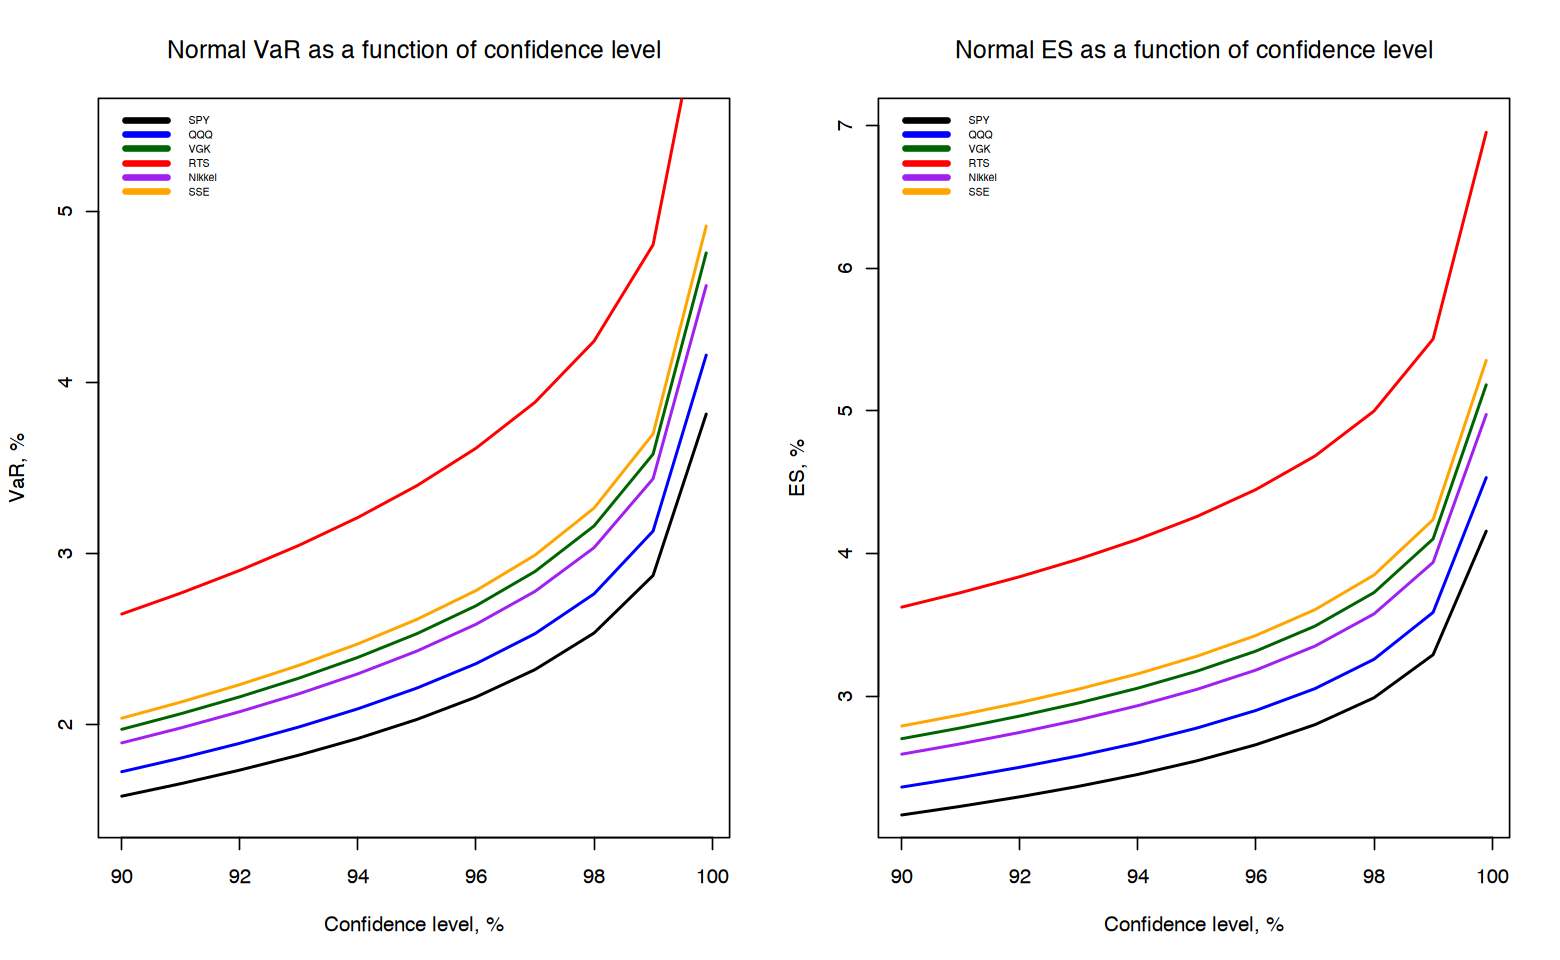

In [116]:
par(mfrow=c(1,2))

options(repr.plot.width=13,repr.plot.height=8)

plot(100*(1-cl),100*var_cl[1,],type='l',main='Normal VaR as a function of confidence level',
       xlab='Confidence level, %',ylab='VaR, %',lwd=1.8, ylim=c(1.5,5.5))
lines(100*(1-cl),100*var_cl[2,],type='l', col='blue',lwd=1.8)
lines(100*(1-cl),100*var_cl[3,],type='l', col='dark green',lwd=1.8)
lines(100*(1-cl),100*var_cl[4,],type='l', col='red',lwd=1.8)
lines(100*(1-cl),100*var_cl[5,],type='l', col='purple',lwd=1.8)
lines(100*(1-cl),100*var_cl[6,],type='l', col='orange',lwd=1.8)
legend('topleft',inset=0.01, bty="n",leg=c('SPY','QQQ','VGK','RTS','Nikkei','SSE'),
         cex=0.5, lwd=4, lty=1, col=c("black", "blue",'dark green','red','purple','orange'))


plot(100*(1-cl),100*es_cl[1,],type='l',main='Normal ES as a function of confidence level',
     xlab='Confidence level, %',ylab='ES, %',lwd=1.8,ylim=c(2.2,7))
lines(100*(1-cl),100*es_cl[2,],type='l', col='blue',lwd=1.8)
lines(100*(1-cl),100*es_cl[3,],type='l', col='dark green',lwd=1.8)
lines(100*(1-cl),100*es_cl[4,],type='l', col='red',lwd=1.8)
lines(100*(1-cl),100*es_cl[5,],type='l', col='purple',lwd=1.8)
lines(100*(1-cl),100*es_cl[6,],type='l', col='orange',lwd=1.8)
legend('topleft',inset=0.01, bty="n",leg=c('SPY','QQQ','VGK','RTS','Nikkei','SSE'),
       cex=0.5, lwd=4, lty=1, col=c("black", "blue",'dark green','red','purple','orange'))


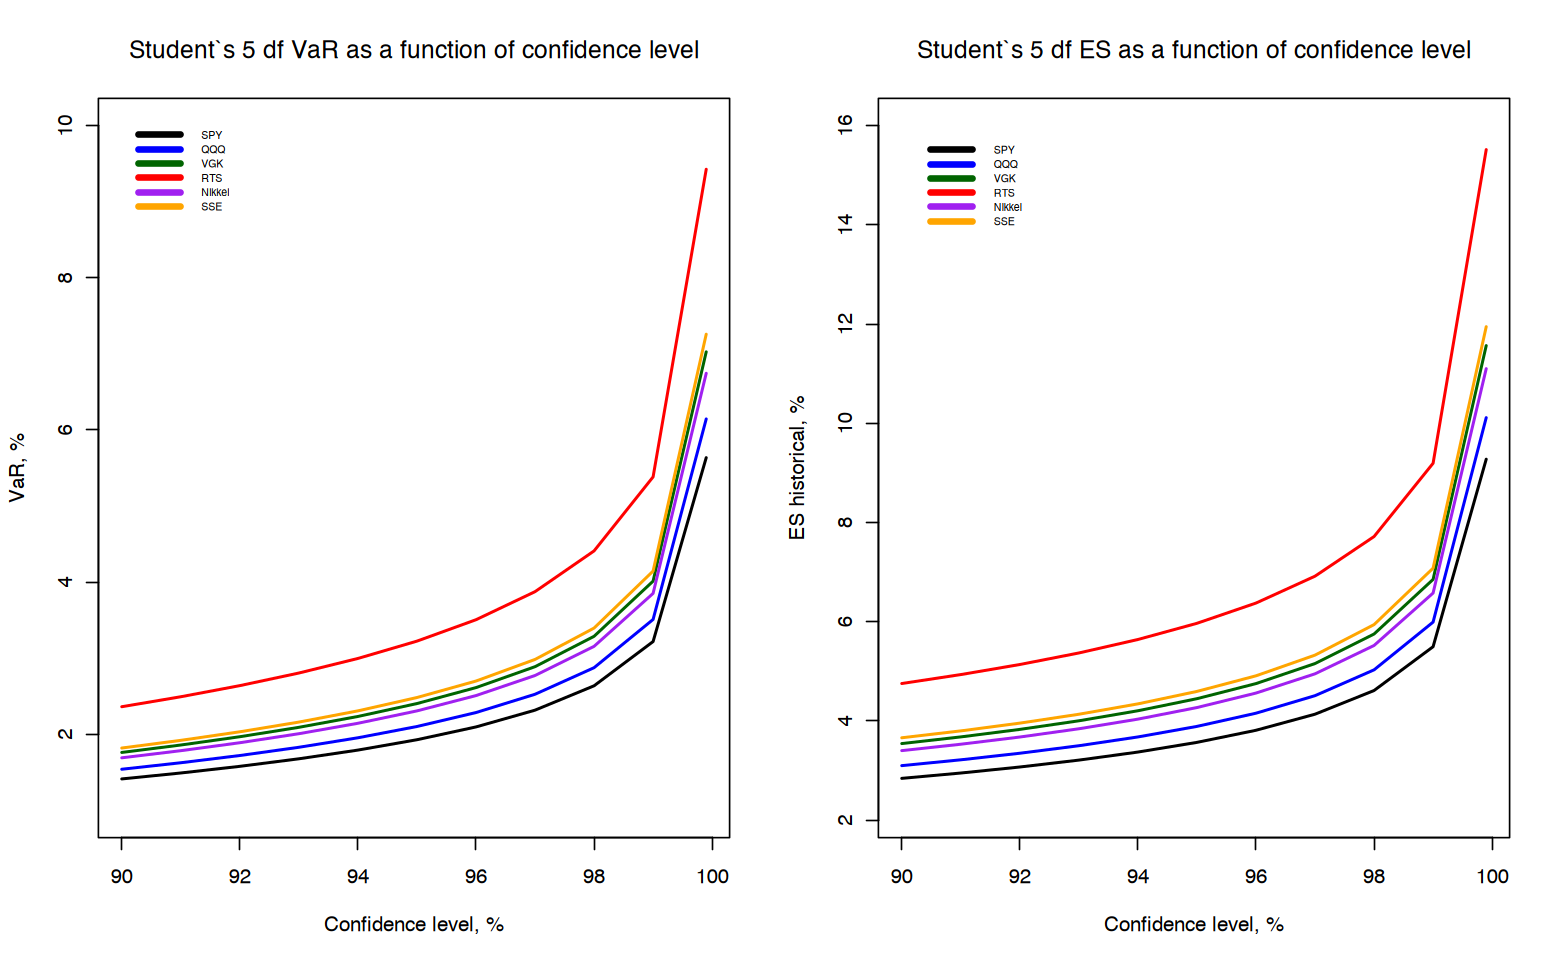

In [129]:
par(mfrow=c(1,2))
options(repr.plot.width=13,repr.plot.height=8)

plot(100*(1-cl),100*var_cl_st[1,],type='l',main='Student`s 5 df VaR as a function of confidence level',
     xlab='Confidence level, %',ylab='VaR, %',lwd=1.8, ylim=c(1,10))
lines(100*(1-cl),100*var_cl_st[2,],type='l', col='blue',lwd=1.8)
lines(100*(1-cl),100*var_cl_st[3,],type='l', col='dark green',lwd=1.8)
lines(100*(1-cl),100*var_cl_st[4,],type='l', col='red',lwd=1.8)
lines(100*(1-cl),100*var_cl_st[5,],type='l', col='purple',lwd=1.8)
lines(100*(1-cl),100*var_cl_st[6,],type='l', col='orange',lwd=1.8)
legend('topleft',inset=0.03, bty="n",leg=c('SPY','QQQ','VGK','RTS','Nikkei','SSE'),
       cex=0.5, lwd=4, lty=1, col=c("black", "blue",'dark green','red','purple','orange'))


plot(100*(1-cl),100*es_cl_st[1,],type='l',main='Student`s 5 df ES as a function of confidence level',
     xlab='Confidence level, %',ylab='ES historical, %',lwd=1.8,ylim=c(2.2,16))
lines(100*(1-cl),100*es_cl_st[2,],type='l', col='blue',lwd=1.8)
lines(100*(1-cl),100*es_cl_st[3,],type='l', col='dark green',lwd=1.8)
lines(100*(1-cl),100*es_cl_st[4,],type='l', col='red',lwd=1.8)
lines(100*(1-cl),100*es_cl_st[5,],type='l', col='purple',lwd=1.8)
lines(100*(1-cl),100*es_cl_st[6,],type='l', col='orange',lwd=1.8)
legend('topleft',inset=0.05, bty="n",leg=c('SPY','QQQ','VGK','RTS','Nikkei','SSE'),
       cex=0.5, lwd=4, lty=1, col=c("black", "blue",'dark green','red','purple','orange'))


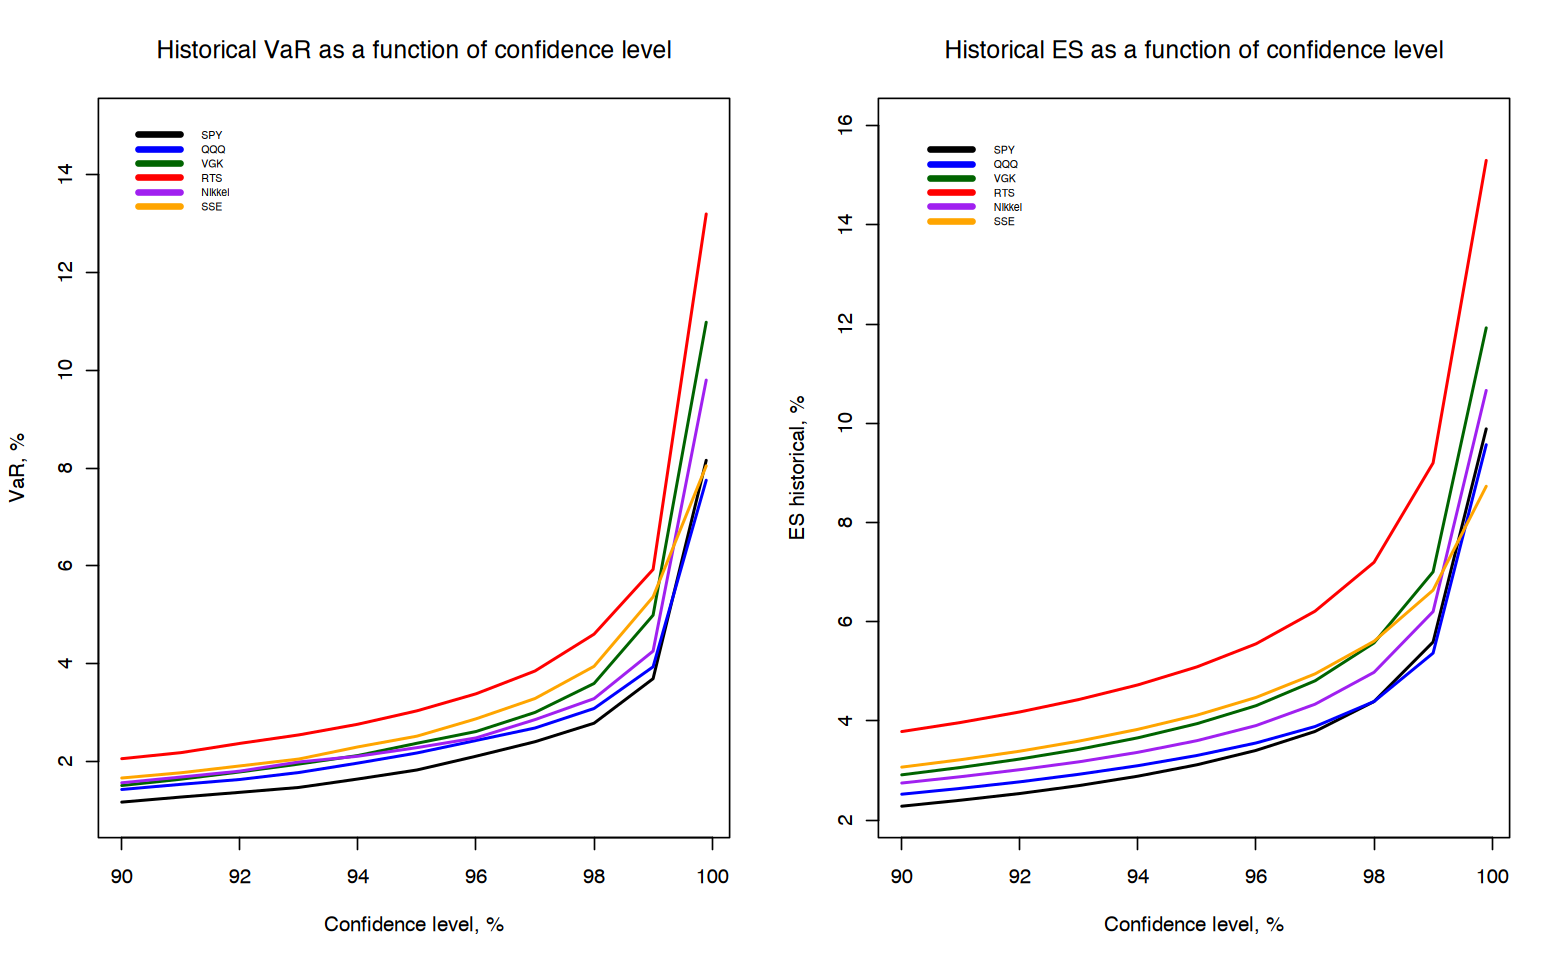

In [153]:
par(mfrow=c(1,2))
options(repr.plot.width=13,repr.plot.height=8)

plot(100*(1-cl),100*var_cl_hs[1,],type='l',main='Historical VaR as a function of confidence level',
     xlab='Confidence level, %',ylab='VaR, %',lwd=1.8, ylim=c(1,15))
lines(100*(1-cl),100*var_cl_hs[2,],type='l', col='blue',lwd=1.8)
lines(100*(1-cl),100*var_cl_hs[3,],type='l', col='dark green',lwd=1.8)
lines(100*(1-cl),100*var_cl_hs[4,],type='l', col='red',lwd=1.8)
lines(100*(1-cl),100*var_cl_hs[5,],type='l', col='purple',lwd=1.8)
lines(100*(1-cl),100*var_cl_hs[6,],type='l', col='orange',lwd=1.8)
legend('topleft',inset=0.03, bty="n",leg=c('SPY','QQQ','VGK','RTS','Nikkei','SSE'),
       cex=0.5, lwd=4, lty=1, col=c("black", "blue",'dark green','red','purple','orange'))


plot(100*(1-cl),100*es_cl_hs[1,],type='l',main='Historical ES as a function of confidence level',
     xlab='Confidence level, %',ylab='ES historical, %',lwd=1.8,ylim=c(2.2,16))
lines(100*(1-cl),100*es_cl_hs[2,],type='l', col='blue',lwd=1.8)
lines(100*(1-cl),100*es_cl_hs[3,],type='l', col='dark green',lwd=1.8)
lines(100*(1-cl),100*es_cl_hs[4,],type='l', col='red',lwd=1.8)
lines(100*(1-cl),100*es_cl_hs[5,],type='l', col='purple',lwd=1.8)
lines(100*(1-cl),100*es_cl_hs[6,],type='l', col='orange',lwd=1.8)
legend('topleft',inset=0.05, bty="n",leg=c('SPY','QQQ','VGK','RTS','Nikkei','SSE'),
       cex=0.5, lwd=4, lty=1, col=c("black", "blue",'dark green','red','purple','orange'))


Plot without RTS index to more clearly see the strange behavior at higher confidence levels

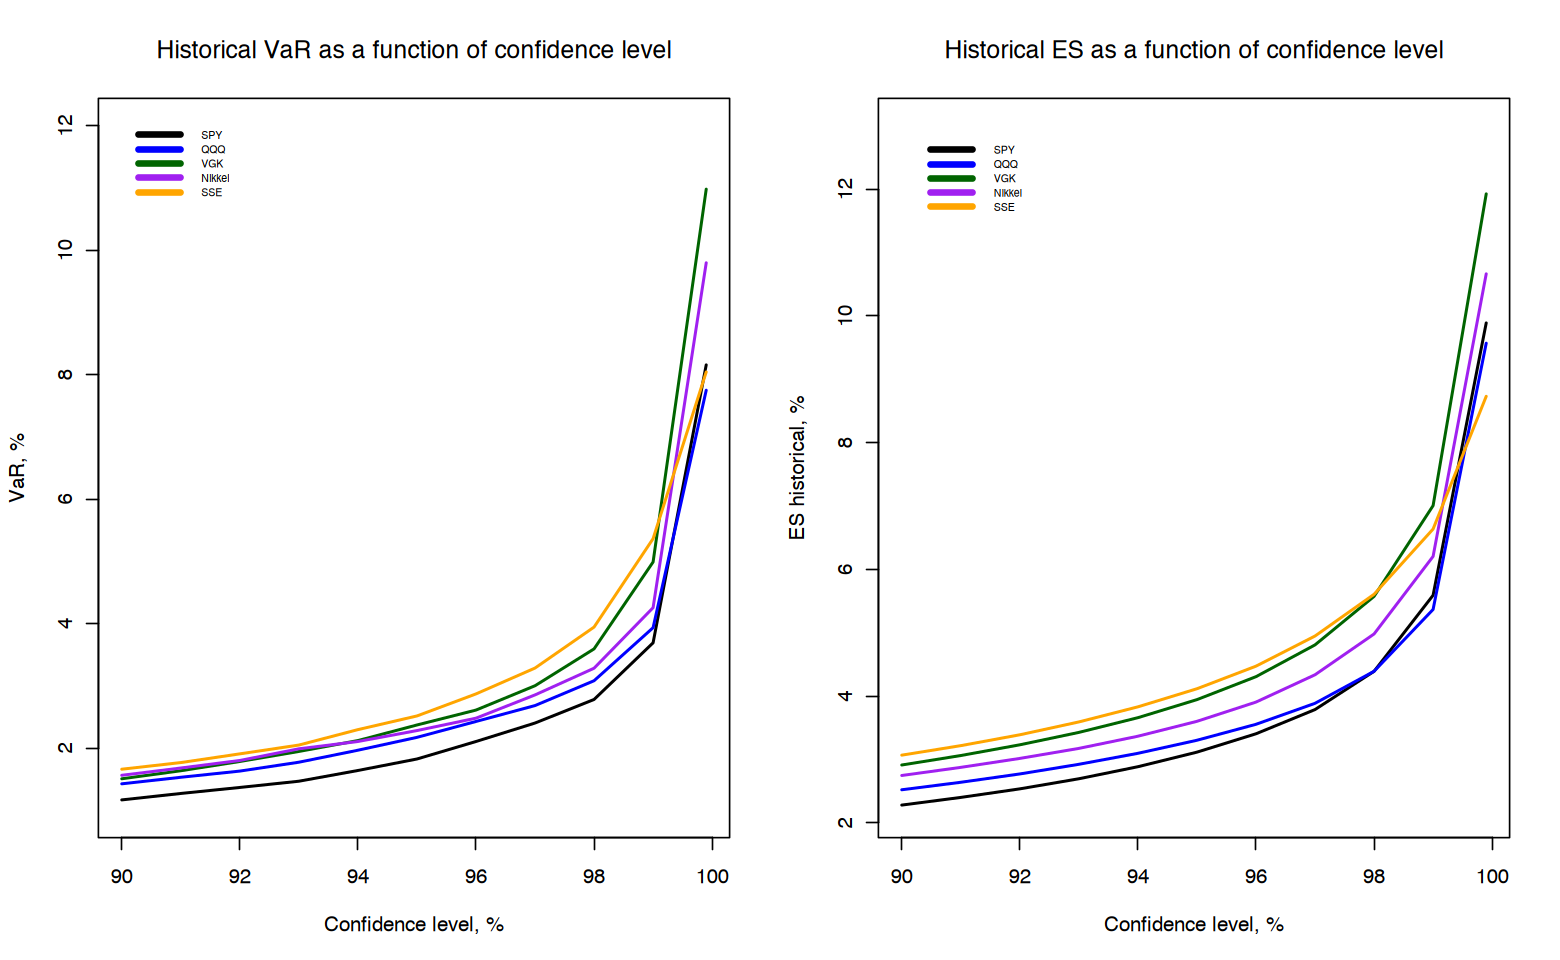

In [152]:
par(mfrow=c(1,2))
options(repr.plot.width=13,repr.plot.height=8)

plot(100*(1-cl),100*var_cl_hs[1,],type='l',main='Historical VaR as a function of confidence level',
     xlab='Confidence level, %',ylab='VaR, %',lwd=1.8, ylim=c(1,12))
lines(100*(1-cl),100*var_cl_hs[2,],type='l', col='blue',lwd=1.8)
lines(100*(1-cl),100*var_cl_hs[3,],type='l', col='dark green',lwd=1.8)
lines(100*(1-cl),100*var_cl_hs[5,],type='l', col='purple',lwd=1.8)
lines(100*(1-cl),100*var_cl_hs[6,],type='l', col='orange',lwd=1.8)
legend('topleft',inset=0.03, bty="n",leg=c('SPY','QQQ','VGK','Nikkei','SSE'),
       cex=0.5, lwd=4, lty=1, col=c("black", "blue",'dark green','purple','orange'))


plot(100*(1-cl),100*es_cl_hs[1,],type='l',main='Historical ES as a function of confidence level',
     xlab='Confidence level, %',ylab='ES historical, %',lwd=1.8,ylim=c(2.2,13))
lines(100*(1-cl),100*es_cl_hs[2,],type='l', col='blue',lwd=1.8)
lines(100*(1-cl),100*es_cl_hs[3,],type='l', col='dark green',lwd=1.8)
lines(100*(1-cl),100*es_cl_hs[5,],type='l', col='purple',lwd=1.8)
lines(100*(1-cl),100*es_cl_hs[6,],type='l', col='orange',lwd=1.8)
legend('topleft',inset=0.05, bty="n",leg=c('SPY','QQQ','VGK','Nikkei','SSE'),
       cex=0.5, lwd=4, lty=1, col=c("black", "blue",'dark green','purple','orange'))

# Impact of time horizon (normality assumption)

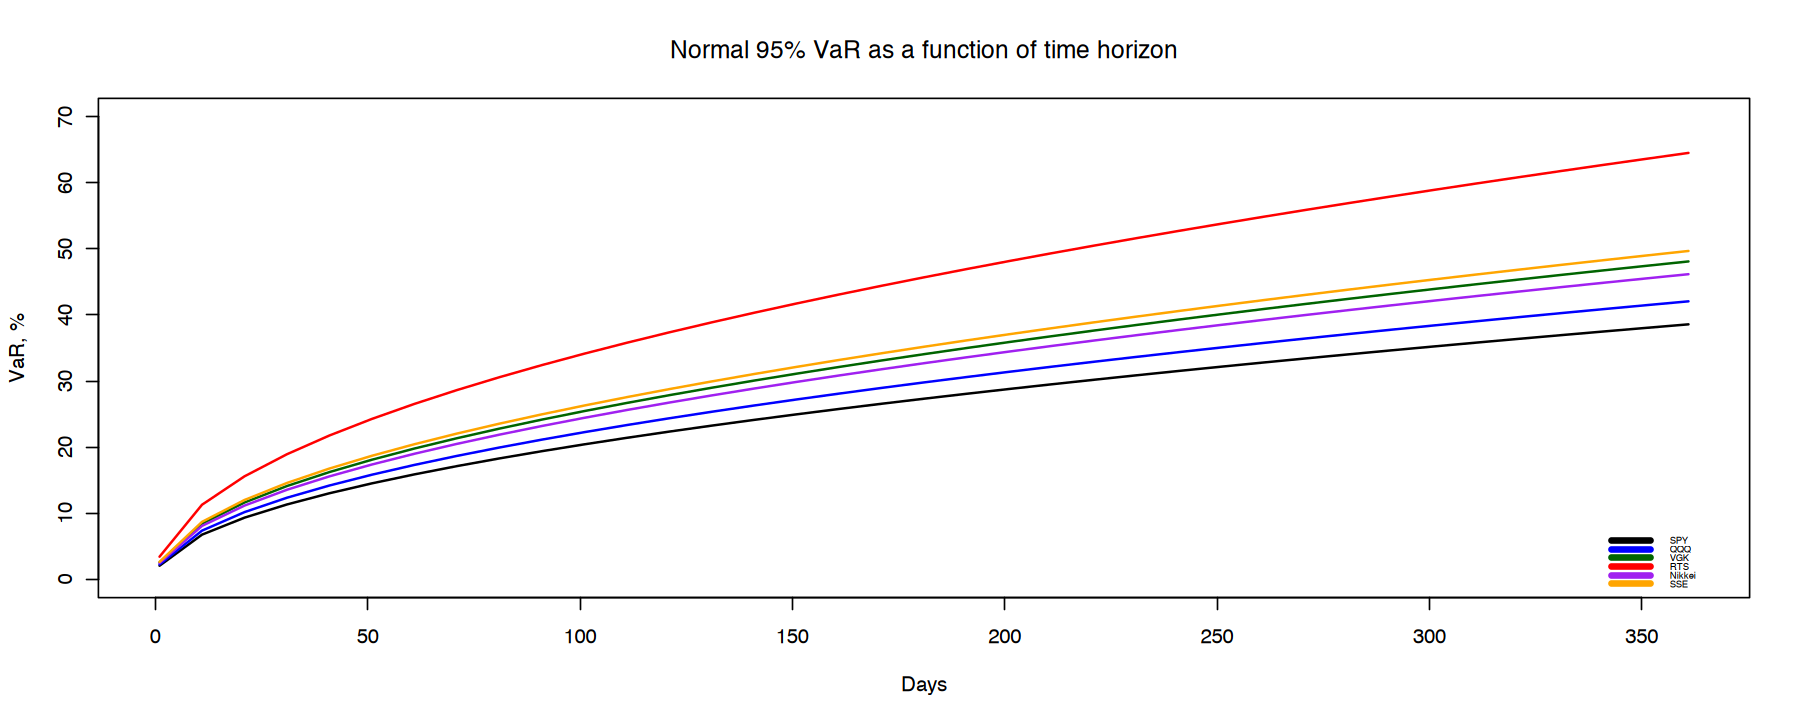

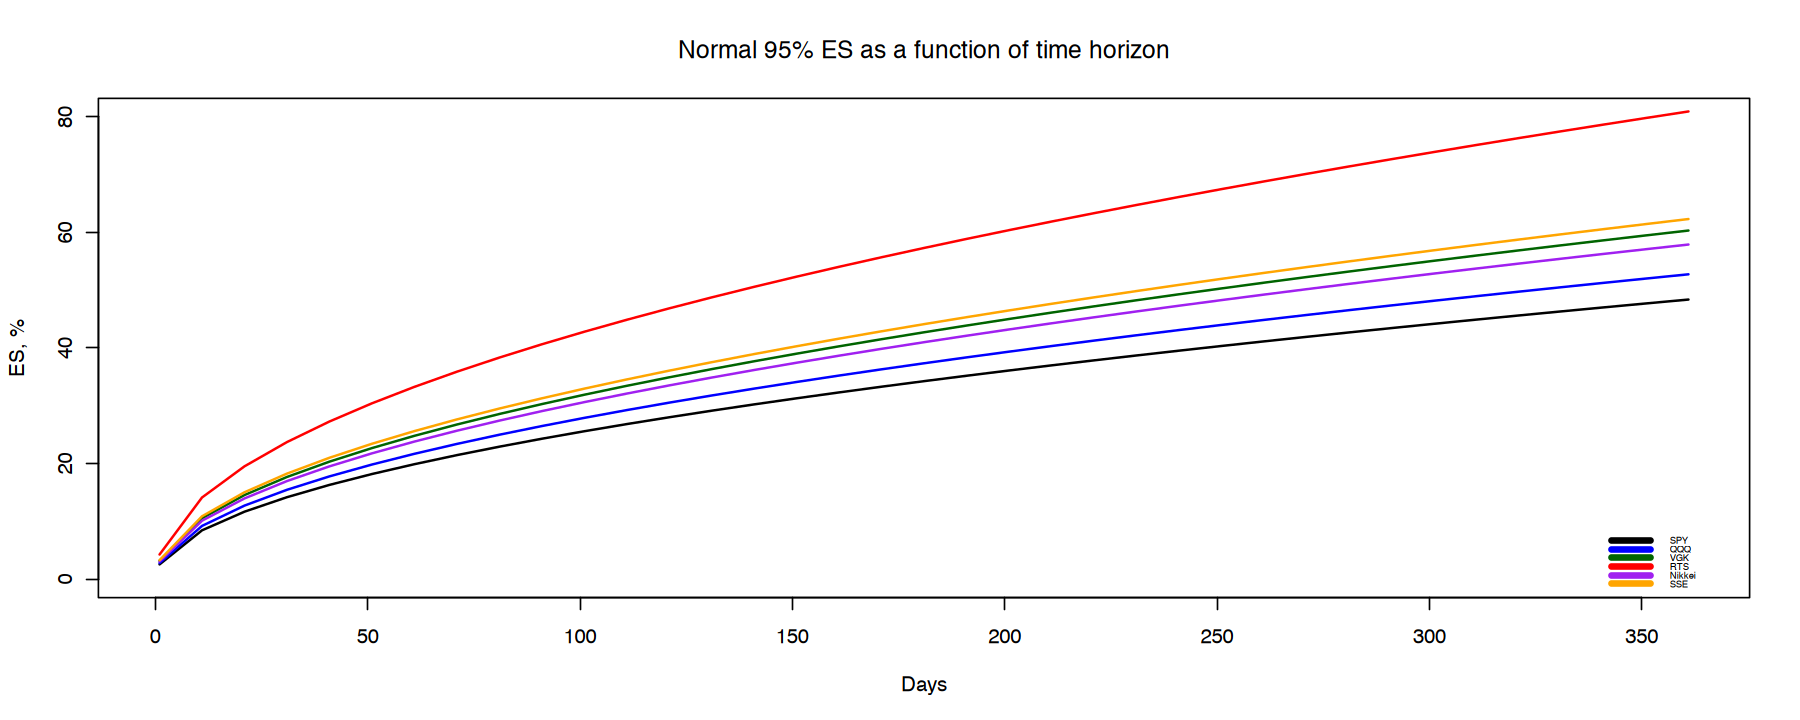

In [158]:
plot(days,100*var_day[1,],type='l',main='Normal 95% VaR as a function of time horizon',
     xlab='Days',ylab='VaR, %',lwd=1.5,ylim=c(0,70))
lines(days,100*var_day[2,],type='l', col='blue',lwd=1.5)
lines(days,100*var_day[3,],type='l', col='dark green',lwd=1.5)
lines(days,100*var_day[4,],type='l', col='red',lwd=1.5)
lines(days,100*var_day[5,],type='l', col='purple',lwd=1.5)
lines(days,100*var_day[6,],type='l', col='orange',lwd=1.5)
legend('bottomright',inset=0.01, bty="n",leg=c('SPY','QQQ','VGK','RTS','Nikkei','SSE'),
       cex=0.45, lwd=4, lty=1, col=c("black", "blue",'dark green','red','purple','orange'))


plot(days,100*es_day[1,],type='l',main='Normal 95% ES as a function of time horizon',
     xlab='Days',ylab='ES, %',lwd=1.5,ylim=c(0,80))
lines(days,100*es_day[2,],type='l', col='blue',lwd=1.5)
lines(days,100*es_day[3,],type='l', col='dark green',lwd=1.5)
lines(days,100*es_day[4,],type='l', col='red',lwd=1.5)
lines(days,100*es_day[5,],type='l', col='purple',lwd=1.5)
lines(days,100*es_day[6,],type='l', col='orange',lwd=1.5)
legend('bottomright',inset=0.01, bty="n",leg=c('SPY','QQQ','VGK','RTS','Nikkei','SSE'),
       cex=0.45, lwd=4, lty=1, col=c("black", "blue",'dark green','red','purple','orange'))

